# Data Science Project: Planning Stage (Individual)
Name: Annie Wu

Course: DSCI 100 – 2025W1

In [1]:
library(tidyverse)
library(ggplot2)
library(dplyr)

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.5.1     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.1
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors


**(1) Data Description**

Here is the question chosen: “What player characteristics and behaviours are most predictive of subscribing to a game-related newsletter, and how do these features differ between various player types?”

Two datasets were provided: [players.csv](players.csv) and [sessions.csv](sessions.csv). For this question, players.csv is selected as the only analytical dataset to use. [players.csv](players.csv) is the most appropriate dataset for answering the research question because it contains the precise types of information needed to predict newsletter subscription. The question focuses specifically on player characteristics and overall behaviours, as well as differences between player types. All of these variables are found within players.csv and not sessions.csv, since the latter dataset is more focused on individual game sessions. 

In total, the dataset includes *196 observations* and *7 variables*, with each row representing a unique player. These variables capture demographic attributes (such as gender and age), self-reported experience level, gameplay hours, and the binary outcome indicating whether the player subscribed to the newsletter. Together, these form a suitable foundation for modelling newsletter subscription behaviour.

The dataset contains seven variables: 
- experience
- subscribe
- hashedEmail
- played_hours
- name
- gender
- Age

The experience variable is a categorical label with values such as “Pro,” “Veteran,” “Regular,” and “Amateur,” and reflects the player’s self-perceived playstyle or expertise. 

The subscribe variable is a *Boolean* indicator that identifies whether each player opted into the game’s newsletter, which serves as the target variable for prediction. 

The hashedEmail field represents email identifiers. 

The played_hours variable measures total hours played. 

The name variable stores the player's name which is not relevant analytically, while the gender and Age variables may be important.


#### Potential unseen issues:**
- Self-reporting bias: Experience level, age, and gender may be inaccurately reported.
- Engagement bias: Players willing to provide demographic info or subscribe may differ systematically from players who do not.
- Temporal bias: The dataset does not include timestamps, so we cannot verify when these values were collected or whether behaviour changed over time.


Here is the summary statistics for the players.csv dataset:

In [2]:
players <- read_csv("players.csv")

players |> summarise(n_players = n(),n_unique_email = n_distinct(hashedEmail))

numeric_summary <- players |> select(where(is.numeric)) |>
pivot_longer(everything(),names_to = "variable", values_to = "value") |>
group_by(variable) |> summarise(
    count  = sum(!is.na(value)),
    mean   = round(mean(value, na.rm = TRUE), 2),
    sd     = round(sd(value, na.rm = TRUE), 2),
    min    = round(min(value, na.rm = TRUE), 2),
    q25    = round(quantile(value, 0.25, na.rm = TRUE), 2),
    median = round(median(value, na.rm = TRUE), 2),
    q75    = round(quantile(value, 0.75, na.rm = TRUE), 2),
    max    = round(max(value, na.rm = TRUE), 2),
    .groups = "drop")

numeric_summary

Rows: 196 Columns: 7
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (4): experience, hashedEmail, name, gender
dbl (2): played_hours, Age
lgl (1): subscribe

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


n_players,n_unique_email
<int>,<int>
196,196


variable,count,mean,sd,min,q25,median,q75,max
<chr>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
Age,194,21.14,7.39,9,17,19.0,22.75,58.0
played_hours,196,5.85,28.36,0,0,0.1,0.60,223.1


#### Interpretation of numeric summary:

**Age:** Mean age is about 21.14 years (SD 7.39). Ages range from 9 to 58, so there are younger players and older adults. There are also 2 missing ages (194/196).

**played_hours:** Very right-skewed, median is only 0.1 hours but the maximum is 223.1 hours. Many players have barely played (0–1 hour), and a few have played a lot.

In [3]:
categorical_summary <- players |>
select(experience, subscribe, gender) |>
mutate(across(everything(), as.character)) |>
pivot_longer(
    cols = everything(),
    names_to = "variable",
    values_to = "value") |>
group_by(variable, value) |>
summarise(
    n = n(),
    prop = round(100 * n / 196, 2),
    .groups = "drop"
  ) |>
  arrange(variable, desc(n))

categorical_summary

variable,value,n,prop
<chr>,<chr>,<int>,<dbl>
experience,Amateur,63,32.14
experience,Veteran,48,24.49
experience,Regular,36,18.37
experience,Beginner,35,17.86
experience,Pro,14,7.14
gender,Male,124,63.27
gender,Female,37,18.88
gender,Non-binary,15,7.65
gender,Prefer not to say,11,5.61


*Hashed email and name are excluded because they are identifiers and they are unique.*

#### Interpretation of categorical summary:

**Experience:** The largest groups are Amateurs and Veterans, while Pros make up the smallest category. The most common experience category is Amateur, representing 32.1% of players.

**Gender:** The most common gender identity is Male, accounting for 63.3% of the dataset.

**Subscribe:** A large majority of players subscribed to the newsletter, with 73.5% marked as TRUE.

*After looking at these tables, we can now identify some potential issues.*

#### Issues visible in the dataset
- Skewed behaviour: played_hours is extremely right-skewed, with most players having very low playtime and a few playing for hundreds of hours.
- Missing values: Age contains two missing entries.
- Imbalanced categories: Far fewer Pro players compared to Amateur and Veteran groups. Subscription outcome is imbalanced (majority subscribed).
- Gender categories are unevenly distributed, with very small counts in some groups.

**(2) Questions**

**Broad Question:** What player characteristics and behaviours are most predictive of subscribing to a game-related newsletter, and how do these features differ between various player types?
#### Specific Question: Can player experience level predict newsletter subscription in the players dataset?

This question uses subscribe as the response variable and experience level as the predictor. Experience level represents different player types (e.g., Amateur, Veteran, Pro), so we can explore whether certain groups are more likely to subscribe. To support the analysis, I can also include other variables (such as played_hours, Age, or gender) as optional secondary predictors.

The players.csv dataset contains one row per player with both subscription status and experience level recorded, making it straightforward to analyze the relationship between the two. I will select the relevant variables, convert experience into a factor, and handle the small number of missing Age values. Since played_hours is right-skewed, I will apply a transformation. After preparing the data, I will apply a predictive method (regression or knn), to evaluate how well experience level predicts newsletter subscription and whether certain player types are more likely to subscribe.

**(3) Exploratory Data Analysis and Visualization**

*Load the datasets into R:*

In [4]:
players <- read_csv("players.csv")
sessions <- read_csv("sessions.csv")

Rows: 196 Columns: 7
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (4): experience, hashedEmail, name, gender
dbl (2): played_hours, Age
lgl (1): subscribe

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Rows: 1535 Columns: 5
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (3): hashedEmail, start_time, end_time
dbl (2): original_start_time, original_end_time

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


*The minimum necessary wrangling to turn the data into a tidy format:*

- the [players.csv](players.csv) dataset is already tidy as each variable is its own column, each observation is its own row and each value is atomic. There is no necessary wrangling to perform.
- the [sessions.csv](sessions.csv) dataset is not fully tidy due to date/time column. The start_time and end_time have two pieces of information stored together (date + time), which is not in a tidy format. Furthermore, the original_start_time and original_end_time are in milliseconds, which should be changed to seconds. 

In [5]:
sessions_tidy <- sessions |>
separate(
    start_time,
    into   = c("start_date", "start_time"),
    sep    = " ",
    fill   = "right", 
    remove = TRUE) |>

separate(
    end_time,
    into   = c("end_date", "end_time"),
    sep    = " ",
    fill   = "right",
    remove = TRUE) |>

mutate(
    original_start_time = original_start_time / 1000,
    original_end_time   = original_end_time / 1000)

The code above shows three changes that was made to change [sessions.csv](sessions.csv) into a tidy format. First, the two separate() calls are to split the original start_time and end_time columns into separate start_date/start_clock and end_date/end_clock columns. This ensures that each cell contains only **one piece of information** (either a date or a time), which is consistent with tidy data principles. Second, the mutate() step converts original_start_time and original_end_time from
milliseconds to seconds by dividing by 1000, so that these variables are stored in a more interpretable and consistent numeric scale. Together, these changes make the dataset tidier and easier to work with in later analysis. 

Here is the tidy format of the sessions dataset:

In [6]:
head(sessions_tidy)

hashedEmail,start_date,start_time,end_date,end_time,original_start_time,original_end_time
<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>
bfce39c89d6549f2bb94d8064d3ce69dc3d7e72b38f431d8aa0c4bf95ccee6bf,30/06/2024,18:12,30/06/2024,18:24,1719770000,1719770000
36d9cbb4c6bc0c1a6911436d2da0d09ec625e43e6552f575d4acc9cf487c4686,17/06/2024,23:33,17/06/2024,23:46,1718670000,1718670000
f8f5477f5a2e53616ae37421b1c660b971192bd8ff77e3398304c7ae42581fdc,25/07/2024,17:34,25/07/2024,17:57,1721930000,1721930000
bfce39c89d6549f2bb94d8064d3ce69dc3d7e72b38f431d8aa0c4bf95ccee6bf,25/07/2024,03:22,25/07/2024,03:58,1721880000,1721880000
36d9cbb4c6bc0c1a6911436d2da0d09ec625e43e6552f575d4acc9cf487c4686,25/05/2024,16:01,25/05/2024,16:12,1716650000,1716650000
bfce39c89d6549f2bb94d8064d3ce69dc3d7e72b38f431d8aa0c4bf95ccee6bf,23/06/2024,15:08,23/06/2024,17:10,1719160000,1719160000


*Compute the mean value for each quantitative variable in the players.csv data set. Report the mean values in a table format:*

The quantitiative variables in the [players.csv](players.csv) dataset are:

- played_hours (Numeric measure of total hours played)
- Age (Numeric measure of player age)

Here is a table of the two mean values:

In [7]:
mean_table <- players |>
  summarise(
    mean_played_hours = mean(played_hours, na.rm = TRUE),
    mean_age = mean(Age, na.rm = TRUE)
  )

mean_table

mean_played_hours,mean_age
<dbl>,<dbl>
5.845918,21.13918


*Here are a few exploratory visualizations of the data that helps understanding:*

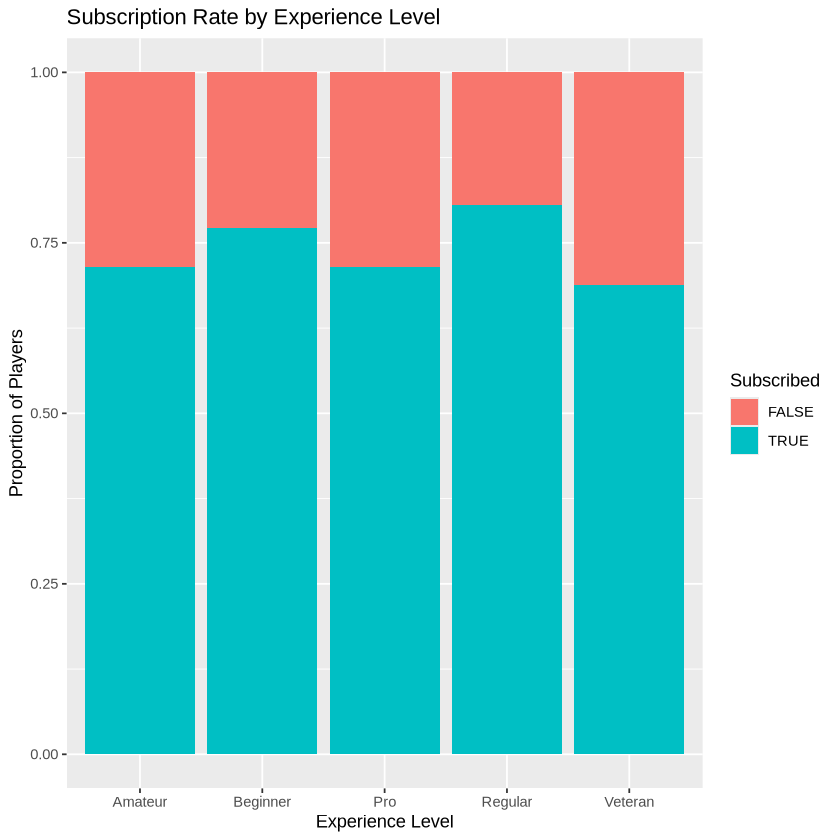

In [8]:
subrate <- players |>
ggplot(aes(x = experience, fill = subscribe)) +
geom_bar(position = "fill") +
labs(title = "Subscription Rate by Experience Level", x = "Experience Level",y = "Proportion of Players", fill = "Subscribed")

subrate

This graph shows the proportion of players who subscribed within each experience level. This shows how subscription likelihood varies across player types, as we can see whether certain groups subscribe more often than others.

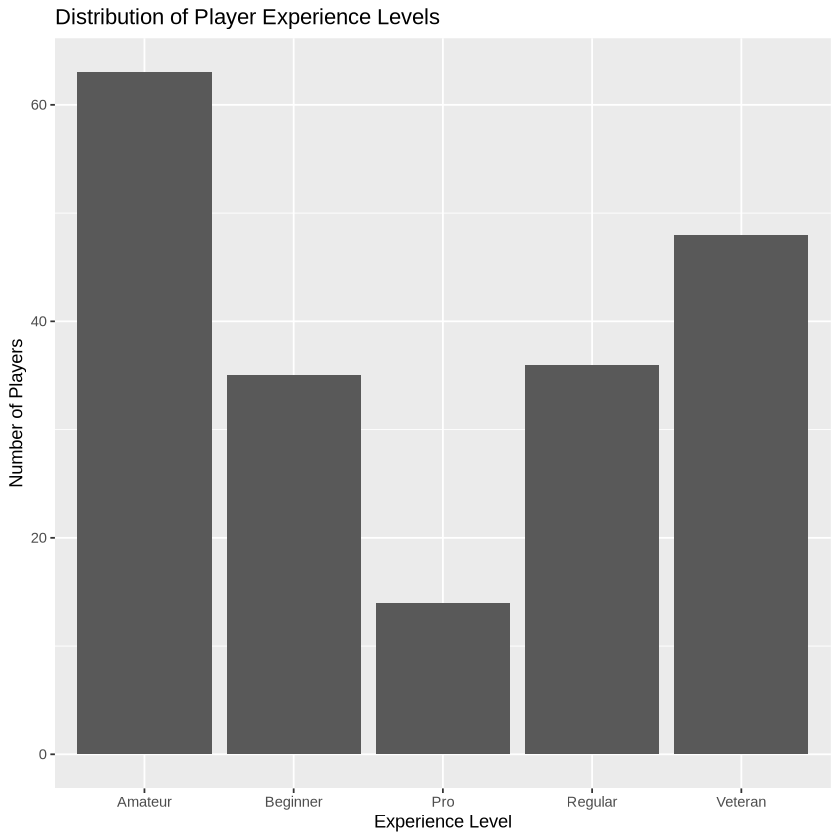

In [9]:
dist <- players |>
ggplot(aes(x = experience)) +
geom_bar() +
labs(title = "Distribution of Player Experience Levels", x = "Experience Level", y = "Number of Players")

dist

This second graph displays the overall distribution of experience levels in the dataset, where we can see which player types are most common and which are not as common. This can also help in noticing any imbalance in the data.

**(4) Methods and Plan**

I will use **KNN** to predict newsletter subscription from experience level because the response is binary and KNN is a classification method that groups players based on similarity. KNN assumes that players who are close in their characteristics will behave similarly. 

K-nearest neighbors regression is a simple, intuitive algorithm, that requires few assumptions about what the data must look like, and works well with non-linear relationships. However, K-nearest neighbors regression becomes very slow as the training data gets larger and may not predict well beyond the range of values input in the training data. It is also weak to variable scaling and imbalanced data. 

To evaluate the model, I will split the data into a 70/30 training–test split and train the model only on the training set. Before modelling, I will scale numeric variables, factorize experience, and handle any missing values.

**(5) GitHub Repository** 

Click here for the [GitHub repository for the project](https://github.com/awu0521/Dsci-11)